In [2]:
import numpy as np
import pandas as pd
import cv2  # OpenCV
import rasterio
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import ee  # Earth Engine API
import geemap
import os
import leaflet
import ipywidgets as widgets

In [8]:
#os.remove(os.path.expanduser('~/.config/earthengine/credentials'))
ee.Authenticate()
ee.Initialize(project='nikolavukasinovic')

# Definišemo područje interesa (AOI) - Stavio da bude moje selo
aoi = ee.Geometry.Polygon([
    [
        [20.611538, 43.045487],  # Ugao 1 (Jugo Zapadna granica)
        [20.619155, 43.045487],  # Ugao 2 (Jugo Istočna granica)
        [20.619155, 43.051737],  # Ugao 3 (Severo Istočna granica)
        [20.611538, 43.051737]   # Ugao 4 (Severo Zapadna granica)
    ]
])

# Učitajte Sentinel-2 snimka za 2022. godinu
dataset = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
            .filterDate('2022-01-01', '2022-12-31') \
            .filterBounds(aoi)
            
# Preuzimanje slike
images = dataset.toList(dataset.size())

image = ee.Image(dataset.first())

vis_params = {
    'bands': ['B4', 'B3', 'B2'],  # RGB bands
    'min': 0,
    'max': 3000,
    'gamma': 1.4
}


# Pravimo mapu za vizuelizaciju
Map = geemap.Map()
Map.centerObject(aoi, 13)
Map.addLayer(image, vis_params, 'RGB Image')
Map.addLayer(aoi, {}, 'AOI')
Map.addLayerControl()
Map

Map(center=[43.048612010054555, 20.615346499989577], controls=(WidgetControl(options=['position', 'transparent…

In [9]:
def calculate_ndvi(image):
    # Racunamo NDVI: (NIR - Red) / (NIR + Red)
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Dodeljujemo NDVI proracun za svaku sliku u kolekciji
dataset_with_ndvi = dataset.map(calculate_ndvi)

# Uzimamo prosecnu sliku u zadnjih godinu dana za NDVI
median_ndvi = dataset_with_ndvi.select('NDVI').median().clip(aoi)

# Postavljamo parametre za NDVI (Normalized Difference Vegetation Index)
ndvi_params = {
    'min': -1,
    'max': 1,
    'palette': ['blue', 'white', 'green']
}

# Visualize NDVI
Map = geemap.Map()
Map.centerObject(aoi, 13)
Map.addLayer(median_ndvi, ndvi_params, 'Median NDVI')
Map.addLayer(aoi, {}, 'AOI')
Map.addLayerControl()
Map

Map(center=[43.048612010054555, 20.615346499989577], controls=(WidgetControl(options=['position', 'transparent…

In [10]:
images_folder = os.path.join(os.getcwd(), 'images')
export_path = os.path.join(images_folder, 'median_ndvi.tif')

# Exportujemo sliku na lokal
geemap.ee_export_image(
    median_ndvi,
    filename=export_path,
    scale=5,
    region=aoi.getInfo()['coordinates']
)


Generating URL ...
Please wait ...
Data downloaded to k:\DetekcijaSuma\images\median_ndvi.tif


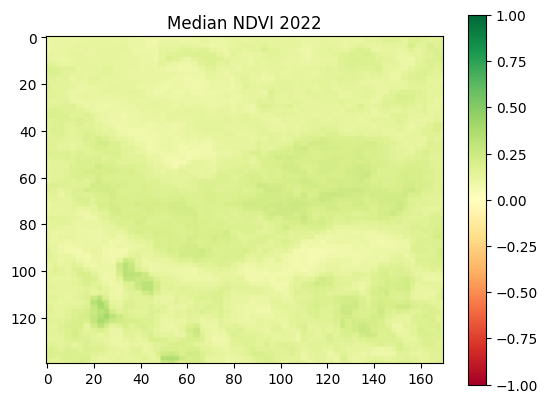

In [18]:
# Ucitavamo exportovanu NDVI sliku
with rasterio.open(export_path) as src:
    ndvi_data = src.read(1)  # Citamo prvi band
    profile = src.profile

# Prikaz NDVI slike
plt.imshow(ndvi_data, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Median NDVI 2022')
plt.show()


In [17]:
# Racunamo NDVI za 2021. godinu
dataset_2021 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterDate('2021-01-01', '2021-12-31') \
    .filterBounds(aoi)

dataset_2021_ndvi = dataset_2021.map(calculate_ndvi)
median_ndvi_2021 = dataset_2021_ndvi.select('NDVI').median().clip(aoi)

# Razlika izmedju dva perioda
ndvi_difference = median_ndvi.subtract(median_ndvi_2021)

# Visualize the NDVI difference
diff_params = {
    'min': -0.5,
    'max': 0.5,
    'palette': ['red', 'white', 'green']
}

Map.addLayer(ndvi_difference, diff_params, 'NDVI Difference')
Map.addLayerControl()
Map


Map(bottom=3081247.0, center=[43.04521313586904, 20.624964237213135], controls=(WidgetControl(options=['positi…

In [22]:
# Oznacio oblast na mapi GFW-a
# Skinuo podatke za tree cover loss
# Skinuo podatke za tree cover by type
# Sacuvao podatke lokalno

# Ucitavanje podataka

import rasterio
import matplotlib.pyplot as plt

# Putanja do skinutih GeoTIFF fajlova
file_path_loss = os.path.join(os.getcwd(), 'treecover_loss')
file_path_type = os.path.join(os.getcwd(), 'treecover_type')

with rasterio.open(file_path_loss) as src:
    tree_cover_loss = src.read(1)  
    profile = src.profile

df = pd.DataFrame(tree_cover_loss, columns=['TreeCoverLoss'])

# Vizualizacija podataka
plt.imshow(tree_cover_loss , cmap='RdYlGn', vmin=0, vmax=1)  
plt.colorbar()
plt.title('Tree Cover Loss')
plt.show()

In [ ]:
#Preprocesing

import json
from rasterio.mask import mask

aoi_geojson = {
    "type": "Polygon",
    "coordinates": [
        [
            [20.611538, 43.045487],
            [20.619155, 43.045487],
            [20.619155, 43.051737],
            [20.611538, 43.051737],
            [20.611538, 43.045487]  # Jos jedna tacka za zatvaranje poligona, kao na Global Forest Watchu
        ]
    ]
}

with open('aoi.geojson', 'w') as f:
    json.dump(aoi_geojson, f)
    

with rasterio.open(file_path_loss) as src:
    out_image, out_transform = mask(src, [aoi_geojson], crop=True)
    out_meta = src.meta.copy()

# Promena metapodataka za klipovanu sliku
out_meta.update({
    "driver": "GTiff",
    "count": 1,
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Cuvanje klipovane slike
clipped_file_path = os.path.join(os.getcwd(), 'clipped_tree_cover_loss.tiff')
with rasterio.open(clipped_file_path, "w", **out_meta) as dest:
    dest.write(out_image)

In [ ]:
import rasterio
import pandas as pd
import matplotlib.pyplot as plt

# Ucitavanje klipovane NDVI slike
with rasterio.open(clipped_file_path) as src:
    tree_cover_loss_data = src.read(1) 
    profile = src.profile

df = pd.DataFrame(tree_cover_loss_data)

df_flat = df.stack().reset_index()
df_flat.columns = ['row', 'col', 'TreeCoverLoss']

threshold = 10
df_flat['Label'] = np.where(df_flat['TreeCoverLoss'] > threshold, 1, 0)


Confusion Matrix:
[[ 869    0]
 [   0 5081]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       869
           1       1.00      1.00      1.00      5081

    accuracy                           1.00      5950
   macro avg       1.00      1.00      1.00      5950
weighted avg       1.00      1.00      1.00      5950



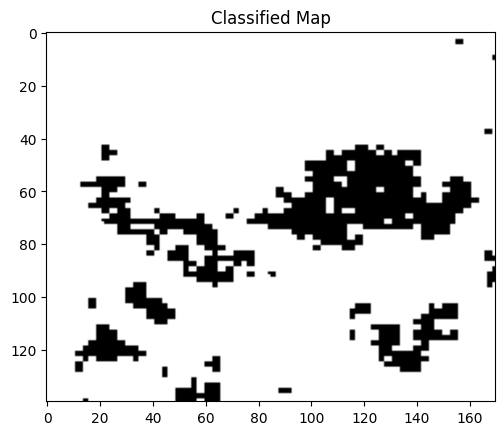

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


# Gde je ndvi manji od 0.2 racunacemo da je pokrceno a ostali ce da upadnu u posumljeno
# Trebalo bi da imam primere pokrcenih i posumljenih delova pa to da mi bude materijal za treniranje
labels = np.where(ndvi_data < 0.2, 1, 0)

# Poravnati NDVI podatke za treniranje ako je potrebno
X = ndvi_data.flatten().reshape(-1, 1)  # Features (NDVI values)
y = labels.flatten()  # Labels (0 for no deforestation, 1 for deforestation)

# Deljenje podataka na train i test skupove u odnosu 75/25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Inicijalizacija RandomForestClassifier sa 100 jedinica
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Treniranje modela
rf_classifier.fit(X_train, y_train)

# Prediktovanje
y_pred = rf_classifier.predict(X_test)

# Evaluacija modela
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Opciono, vizualizacija klasifikovane mape
classified_map = rf_classifier.predict(X).reshape(ndvi_data.shape)
plt.imshow(classified_map, cmap='gray')
plt.title('Classified Map')
plt.show()
